<a href="https://colab.research.google.com/github/Piat0046/PractiseProject/blob/master/Project2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install shap
#!pip install pdpbox
!pip install xgboost
!pip install category_encoders
!pip install lightgbm
#!pip install matplotlib_inline

#데이터 불러오기

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porject2/match_master.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porject2/match_Diamonds2.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porject2/match_grandmaster.csv')
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porject2/match_Diamonds.csv')
df4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porject2/match_Platinums.csv')
df5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porject2/match_Diamonds34.csv')

In [ ]:
df = pd.concat([df, df1])
df = pd.concat([df, df2])
df = pd.concat([df, df3])
df = pd.concat([df, df4])
df = pd.concat([df, df5])

#EDA진행

In [ ]:
##ban데이터중 필요한없는 문자열 제거
df = df.drop_duplicates()
df = df.drop(df[df['bans'].str.contains('\[\]')].index)       ##ban데이터가 아예없는 행제거
df['bans'] = df['bans'].str.replace(' ','', regex=True)
df['bans'] = df['bans'].str.replace('[','', regex=True)
df['bans'] = df['bans'].str.replace(']','', regex=True)
df['bans'] = df['bans'].str.replace('{','', regex=True)
df['bans'] = df['bans'].str.replace('}','', regex=True)
df['bans'] = df['bans'].str.replace('\'championId\':','', regex=True)
df = df.reset_index(drop = True)
df['teamId'] = df['teamId'].astype(object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


##PCA용 밴데이터


In [ ]:
##ban데이터 분할
ban = []
bans1 = []

for i in tqdm(range(len(df['bans']))):
    ban = []
    for b in [0,2,4,6,8]:
        if b == 0:
            ban.append(df['bans'][i].split(',')[b])
        elif b == 2:
            ban.append(df['bans'][i].split(',')[b])
        elif b == 4:
            ban.append(df['bans'][i].split(',')[b])
        elif b == 6:
            ban.append(df['bans'][i].split(',')[b])
        elif b == 8:
            ban.append(df['bans'][i].split(',')[b])
    ban = list(map(int, ban))
    ban = sorted(ban)
    bans1.append(ban)
bans = pd.DataFrame(bans1, columns=['ban1', 'ban2','ban3','ban4','ban5'])

100%|██████████| 64506/64506 [00:02<00:00, 24865.92it/s]


In [ ]:
bans.head()

,ban1,ban2,ban3,ban4,ban5
0,62,78,117,222,238
1,89,101,112,238,421
2,30,51,58,238,412
3,23,30,51,91,104
4,23,24,99,166,202
...,...,...,...,...,...
64501,81,89,112,223,711
64502,-1,7,39,166,555
64503,-1,24,53,89,238
64504,-1,84,91,131,238


##기존 밴데이터

In [ ]:
##ban데이터 분할
ban = []
ban1 = []
ban2 = []
ban3 = []
ban4 = []
ban5 = []

for i in tqdm(range(len(df['bans']))):
    for b in [0,2,4,6,8]:
        if b == 0:
            ban1.append(df['bans'][i].split(',')[b])
        elif b == 2:
            ban2.append(df['bans'][i].split(',')[b])
        elif b == 4:
            ban3.append(df['bans'][i].split(',')[b])
        elif b == 6:
            ban4.append(df['bans'][i].split(',')[b])
        elif b == 8:
            ban5.append(df['bans'][i].split(',')[b])

100%|██████████| 64506/64506 [00:02<00:00, 27069.88it/s]


In [ ]:
##ban데이터 데이터프레임 생성
bans2 = pd.DataFrame([ban1,ban2,ban3,ban4,ban5],index = ['ban1','ban2','ban3','ban4','ban5']).T 

In [ ]:
bans2.head()

,ban1,ban2,ban3,ban4,ban5
0,117,222,78,238,62
1,421,112,89,238,101
2,30,412,238,51,58
3,91,23,104,30,51
4,99,23,166,24,202


## 타겟데이터 불균형 확인

### 승리팀과 패배팀의 데이터 비율 확인

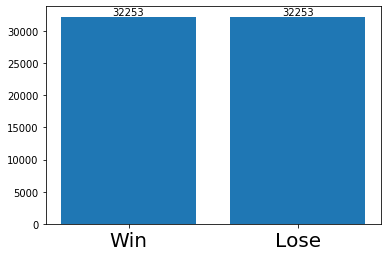

In [ ]:
import matplotlib.pyplot as plt

Win = (df['win']==True).sum()
Lose = (df['win']==False).sum()

plt.bar(np.arange(2),(Win, Lose),align='center', alpha=1)
plt.xticks(np.arange(2), ('Win','Lose'),fontsize = 20)
plt.text(0,Win,Win,ha='center', va= 'bottom',fontsize = 10)
plt.text(1,Lose,Lose,ha='center', va= 'bottom',fontsize = 10);  ##데이터의 갯수 동일

In [ ]:
#승자팀, 패배팀 분리
win_data = df[df['win'] == True]
lose_data = df[df['win'] == False]


#firstblood count
win_fblood = (win_data['firstBlood'] == True).value_counts()
lose_fblood = (lose_data['firstBlood'] == True).value_counts()

#firstower count
win_ftower = (win_data['firstTower'] == True).value_counts()
lose_ftower = (lose_data['firstTower'] == True).value_counts()

#firstInhibitor count
win_finhi = (win_data['firstInhibitor'] == True).value_counts()
lose_finhi = (lose_data['firstInhibitor'] == True).value_counts()

#firstBaron count
win_fbaron = (win_data['firstBaron'] == True).value_counts()
lose_fbaron = (lose_data['firstBaron'] == True).value_counts()

#firstDragon count
win_fdragon = (win_data['firstDragon'] == True).value_counts()
lose_fdragon = (lose_data['firstDragon'] == True).value_counts()

#firstRiftHerald count
win_frift = (win_data['firstRiftHerald'] == True).value_counts()
lose_frift = (lose_data['firstRiftHerald'] == True).value_counts()

data_pie = pd.DataFrame({'WinFBlood':[win_fblood[0],win_fblood[1]],
                         'LoseBlood':[lose_fblood[0],lose_fblood[1]],
    
                         'WinFtower':[win_ftower[0],win_ftower[1]],
                         'LoseFtower':[lose_ftower[0],lose_ftower[1]],

                         'WinFinhibitor':[win_finhi[0],win_finhi[1]],
                         'LoseFinhibitor':[lose_finhi[0],lose_finhi[1]],

                         'WinFbaron':[win_fbaron[0],win_fbaron[1]],
                         'LoseFbaron':[lose_fdragon[0],lose_fdragon[1]],

                         'WinFDragon':[win_fdragon[0],win_fdragon[1]],
                         'LoseFDragon':[lose_fdragon[0],lose_fdragon[1]],                         

                         'WinFRiftHerald':[win_frift[0],win_frift[1]],
                         'LoseFRiftHerald':[lose_frift[0],lose_frift[1]]
                         })

data_pie

,WinFBlood,LoseBlood,WinFtower,LoseFtower,WinFinhibitor,LoseFinhibitor,WinFbaron,LoseFbaron,WinFDragon,LoseFDragon,WinFRiftHerald,LoseFRiftHerald
0,13055,19253,8835,23615,9550,30573,14571,20694,11882,20694,12429,20262
1,19198,13000,23418,8638,22703,1680,17682,11559,20371,11559,19824,11991


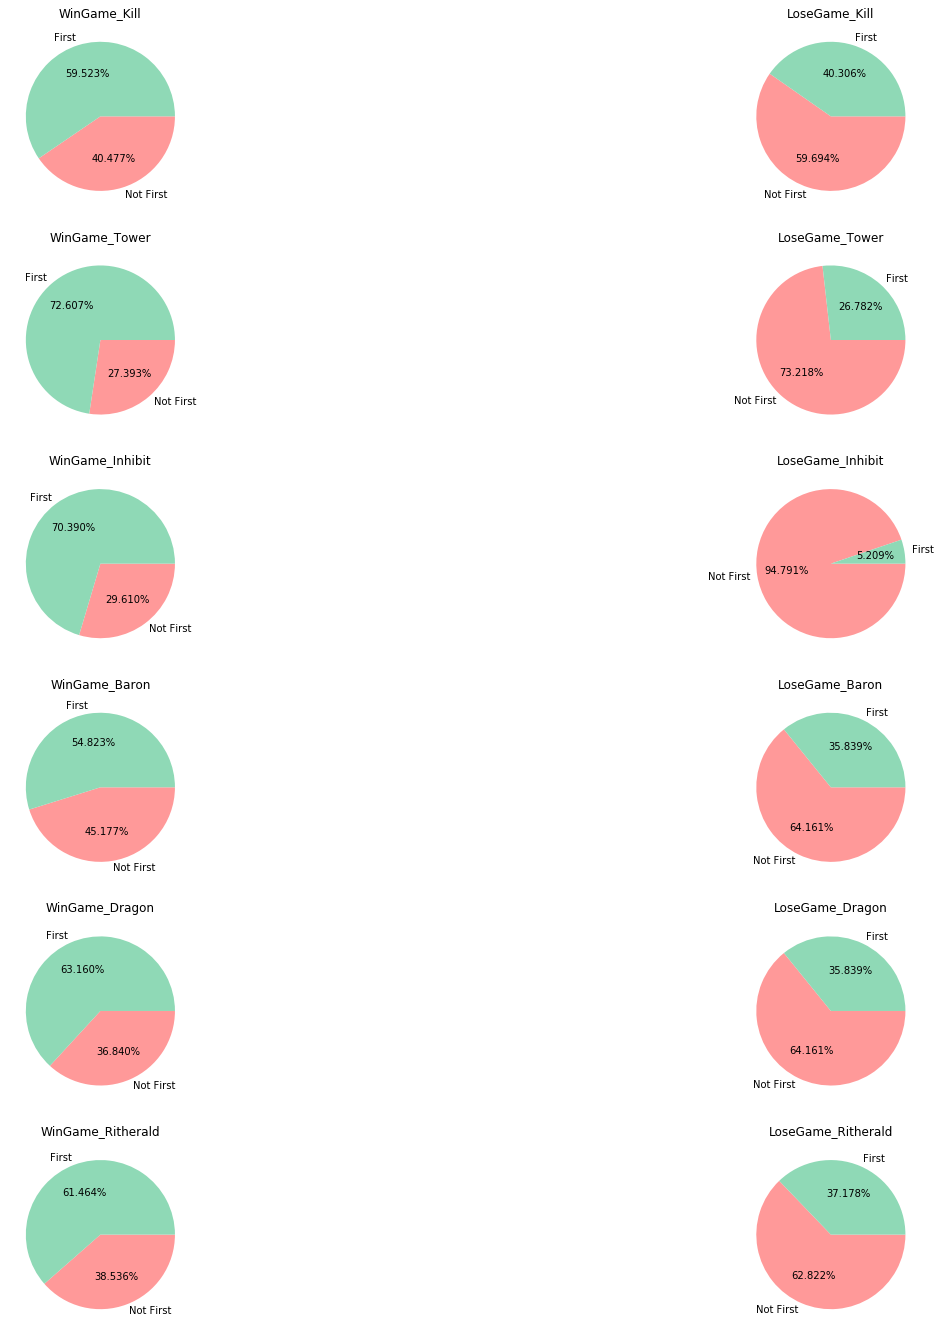

In [ ]:
a = np.array(data_pie)

colors = ['#FF9999', '#8fd9b6']
fig, axes = plt.subplots(6,2,figsize=(24,24))

num = 0
for i in range(6):
    for j in range(2):
        axes[i][j].pie((a[0][num],a[1][num]),labels=['Not First','First'],autopct='%.3f%%', startangle=360, counterclock=False, colors = colors)
        num += 1

axes[0][0].set_title("WinGame_Kill")
axes[0][1].set_title("LoseGame_Kill")        
axes[1][0].set_title("WinGame_Tower")
axes[1][1].set_title("LoseGame_Tower")    
axes[2][0].set_title("WinGame_Inhibit")
axes[2][1].set_title("LoseGame_Inhibit")    
axes[3][0].set_title("WinGame_Baron")
axes[3][1].set_title("LoseGame_Baron")  
axes[4][0].set_title("WinGame_Dragon")
axes[4][1].set_title("LoseGame_Dragon")    
axes[5][0].set_title("WinGame_Ritherald")
axes[5][1].set_title("LoseGame_Ritherald")    

plt.show()

#훈련데이터, 검증데이터 분류

In [ ]:
df = pd.concat([df,bans], axis = 1)   ##기존 데이터와 ban데이터 합침
df = df.drop(['bans'],axis =1)        ##기존 bans행 제거
df = df.drop(['gameId'],axis =1)      ##gameId행 제거

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
 
train, val =  train_test_split(df, test_size=0.2, train_size= 0.8, random_state=10)

In [ ]:
ban_train = train.iloc[:,14:19]
train = train.drop(train.iloc[:,14:19], axis =1)
ban_val = val.iloc[:,14:19]
val = val.drop(val.iloc[:,14:19], axis =1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

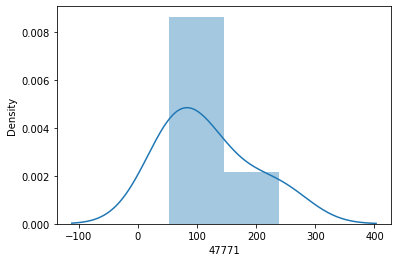

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

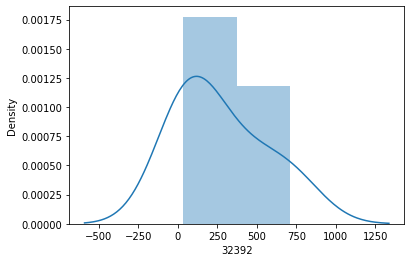

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

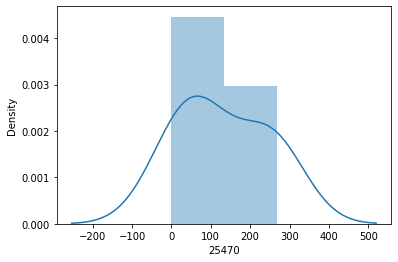

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

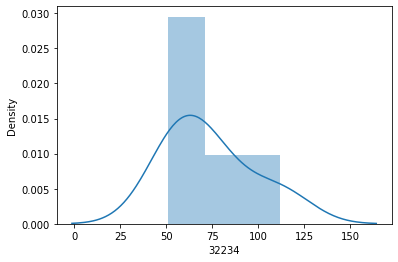

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

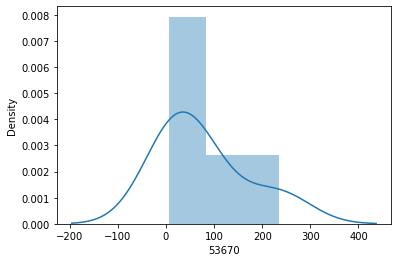

In [ ]:
import seaborn as sns

## ban_train 정규분포확인
for i in range(ban_train.shape[1]):
    sns.distplot(ban_train.iloc[i])
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

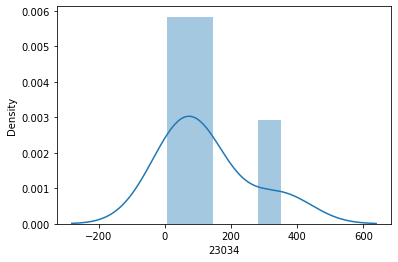

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

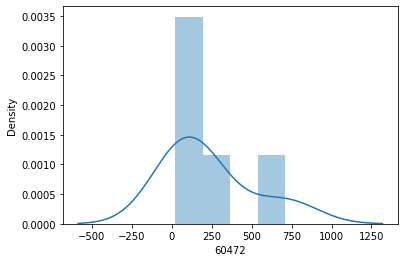

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

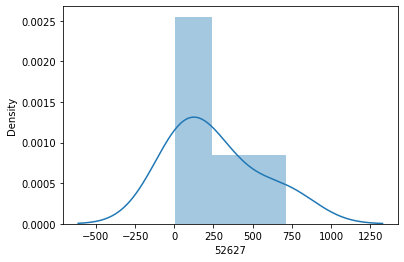

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

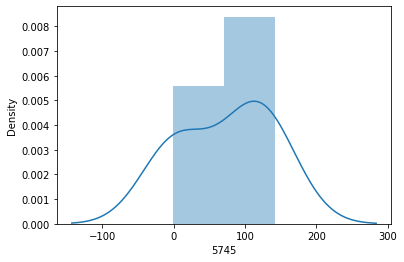

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dime

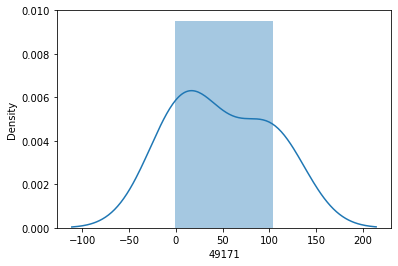

In [ ]:
## ban_val 정규분포확인
for i in range(ban_val.shape[1]):
    sns.distplot(ban_val.iloc[i])
    plt.show()  ## 전체적인 정규분포 확인 -> PCA진행

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
##------------- train ban PCA
pca = PCA(n_components=2)
ban_train = StandardScaler().fit_transform(ban_train)
pca.fit(ban_train)
bans_pca = pca.transform(ban_train)
ban_train = pd.DataFrame(bans_pca, columns= ['ban_pca1','ban_pca2'])
train = train.reset_index(drop= True)
train = pd.concat([train, ban_train], axis = 1)

In [ ]:
##------------- val ban PCA
pca = PCA(n_components=2)
ban_val = StandardScaler().fit_transform(ban_val)
pca.fit(ban_val)
bans_pca = pca.transform(ban_val)
ban_val = pd.DataFrame(bans_pca, columns= ['ban_pca1','ban_pca2'])
val = val.reset_index(drop= True)
val = pd.concat([val, ban_val], axis = 1)

In [ ]:
target = 'win'
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

In [ ]:
from category_encoders import OrdinalEncoder
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

##Random Forest 모델

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline
rf = RandomForestClassifier(n_estimators= 500,
                           n_jobs=-1,
                           max_depth = 7,
                           min_samples_leaf = 1,
                           random_state = 10)

rf.fit(X_train_encoded, y_train);

              precision    recall  f1-score   support

       False       0.88      0.87      0.88      6468
        True       0.87      0.88      0.88      6434

    accuracy                           0.88     12902
   macro avg       0.88      0.88      0.88     12902
weighted avg       0.88      0.88      0.88     12902



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[0.8764532630599907, 0.8764532630599907, 0.9525060151225834]


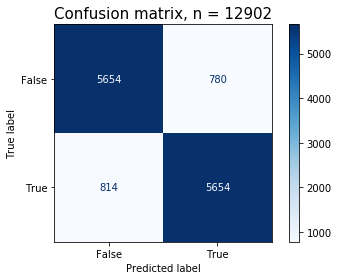

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, plot_confusion_matrix
y_pred_rf = rf.predict(X_val_encoded)
y_pred_rf_proba = rf.predict_proba(X_val_encoded)[:, -1]
print(classification_report(y_pred_rf, y_val))

rf_score = [accuracy_score(y_val,y_pred_rf), f1_score(y_val, y_pred_rf), roc_auc_score(y_val, y_pred_rf_proba)]


fig, ax = plt.subplots()
pcm = plot_confusion_matrix(rf, X_val_encoded, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15);

print(rf_score)

#XGBoost 모델 평가

##GridSearchCV 진행모델


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
xgb = XGBClassifier(n_jobs=-1,
                    random_state = 10)

dists = {'n_estimators' : [100,200,300,400,500,600],
        'learning_rate': [0.1, 0.2, 0.3],
        'max_depth' : [4,5,6,7]
        }

clf_xgb = GridSearchCV(
    xgb, 
    param_grid = dists,  
    cv=3, 
    scoring='f1',  
    verbose=1,
    )

clf_xgb.fit(X_train_encoded, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


KeyboardInterrupt: ignored

In [ ]:
clf_xgb.best_estimator_

##GridSearchCV 이후 수동조정

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(
                    learning_rate=0.1,
                    max_depth=5,
                    n_estimators=500, n_jobs=-1,
                    random_state=10,
                    )

evals = [(X_val_encoded, y_val)]

xgb.fit(X_train_encoded, y_train, early_stopping_rounds=100, eval_metric="error", eval_set=evals, verbose=True)

[0]	validation_0-error:0.125562
Will train until validation_0-error hasn't improved in 100 rounds.
[1]	validation_0-error:0.125097
[2]	validation_0-error:0.125949
[3]	validation_0-error:0.125174
[4]	validation_0-error:0.125329
[5]	validation_0-error:0.124089
[6]	validation_0-error:0.122152
[7]	validation_0-error:0.122074
[8]	validation_0-error:0.121144
[9]	validation_0-error:0.121454
[10]	validation_0-error:0.120756
[11]	validation_0-error:0.121377
[12]	validation_0-error:0.120911
[13]	validation_0-error:0.120756
[14]	validation_0-error:0.118896
[15]	validation_0-error:0.118199
[16]	validation_0-error:0.117811
[17]	validation_0-error:0.117889
[18]	validation_0-error:0.116726
[19]	validation_0-error:0.118121
[20]	validation_0-error:0.117036
[21]	validation_0-error:0.116881
[22]	validation_0-error:0.118044
[23]	validation_0-error:0.118044
[24]	validation_0-error:0.117889
[25]	validation_0-error:0.117114
[26]	validation_0-error:0.116959
[27]	validation_0-error:0.117424
[28]	validation_0-e

XGBClassifier(max_depth=5, n_estimators=500, n_jobs=-1, random_state=10)

              precision    recall  f1-score   support

       False       0.87      0.90      0.88      6265
        True       0.90      0.88      0.89      6637

    accuracy                           0.89     12902
   macro avg       0.89      0.89      0.89     12902
weighted avg       0.89      0.89      0.89     12902

[0.8858316540071307, 0.8876001526135063, 0.9578772850593313]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


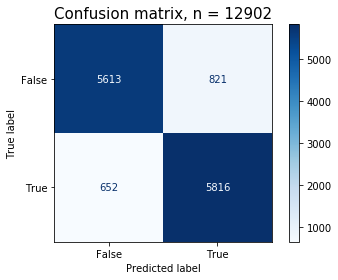

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
y_pred_xgb = xgb.predict(X_val_encoded)
y_pred_xgb_proba = xgb.predict_proba(X_val_encoded)[:, -1]
print(classification_report(y_pred_xgb, y_val))

xgb_score = [accuracy_score(y_val,y_pred_xgb), f1_score(y_val, y_pred_xgb), roc_auc_score(y_val, y_pred_xgb_proba)]

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(xgb, X_val_encoded, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15);

print(xgb_score)

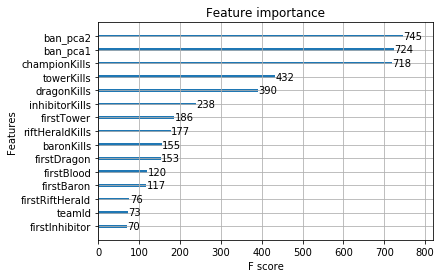

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots()
plot_importance(xgb, ax = ax);

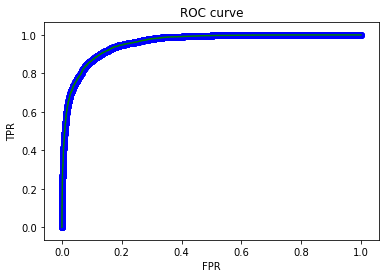

In [ ]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR');

##LGBOOST모델


In [ ]:
from lightgbm import LGBMClassifier, plot_importance
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline


lgb = LGBMClassifier(n_jobs=-1,
                     n_estimators = 500,
                     max_depth = 6,
                     learning_rate = 0.1,                     
                     random_state = 10)
evals = [(X_val_encoded, y_val)]

lgb.fit(X_train_encoded, y_train, early_stopping_rounds=100, eval_metric="error", eval_set=evals, verbose=True)

[1]	valid_0's binary_error: 0.125872	valid_0's binary_logloss: 0.631613
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_error: 0.125097	valid_0's binary_logloss: 0.581316
[3]	valid_0's binary_error: 0.125949	valid_0's binary_logloss: 0.539563
[4]	valid_0's binary_error: 0.125174	valid_0's binary_logloss: 0.50446
[5]	valid_0's binary_error: 0.125174	valid_0's binary_logloss: 0.474605
[6]	valid_0's binary_error: 0.123934	valid_0's binary_logloss: 0.449149
[7]	valid_0's binary_error: 0.122152	valid_0's binary_logloss: 0.427129
[8]	valid_0's binary_error: 0.121067	valid_0's binary_logloss: 0.408067
[9]	valid_0's binary_error: 0.121144	valid_0's binary_logloss: 0.391672
[10]	valid_0's binary_error: 0.120524	valid_0's binary_logloss: 0.377354
[11]	valid_0's binary_error: 0.120369	valid_0's binary_logloss: 0.364714
[12]	valid_0's binary_error: 0.119981	valid_0's binary_logloss: 0.353749
[13]	valid_0's binary_error: 0.119129	valid_0's binary_logloss: 0.34405

LGBMClassifier(max_depth=5, n_estimators=500, random_state=10)

              precision    recall  f1-score   support

       False       0.87      0.90      0.88      6280
        True       0.90      0.88      0.89      6622

    accuracy                           0.89     12902
   macro avg       0.89      0.89      0.89     12902
weighted avg       0.89      0.89      0.89     12902



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[0.8863742055495272, 0.8880061115355233, 0.9578160092420273]

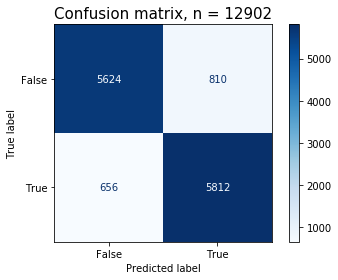

In [ ]:
y_pred_lgb = lgb.predict(X_val_encoded)
y_pred_lgb_proba = lgb.predict_proba(X_val_encoded)[:, -1]
print(classification_report(y_pred_lgb, y_val))

lgb_score = [accuracy_score(y_val,y_pred_lgb), f1_score(y_val, y_pred_lgb), roc_auc_score(y_val, y_pred_lgb_proba)]


fig, ax = plt.subplots()
pcm = plot_confusion_matrix(lgb, X_val_encoded, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15);
lgb_score

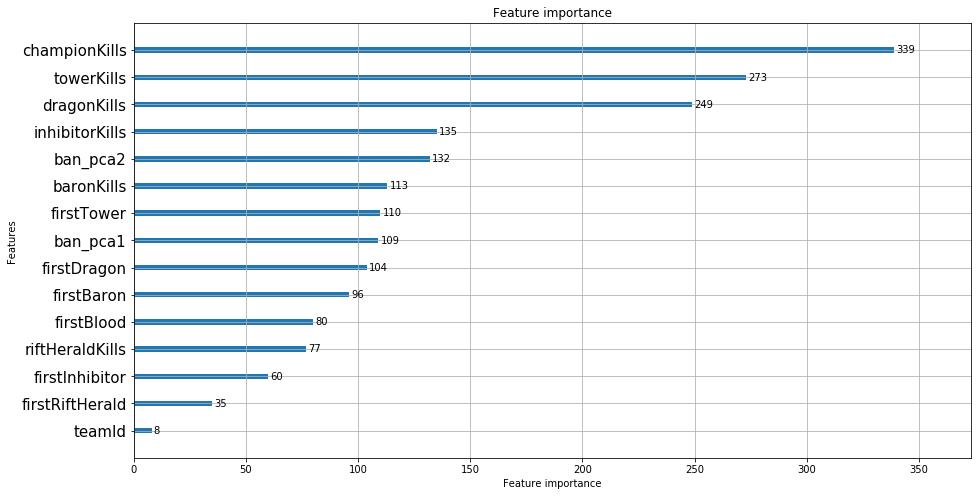

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_importance(lgb, ax = ax);
plt.yticks(fontsize = 15,rotation = 0);

#모델 분석

,accuracy,f1,ACU
rf_score,0.876453,0.876453,0.952506
xgb_score,0.885832,0.887600,0.957877
lgb_score,0.886529,0.887953,0.958018


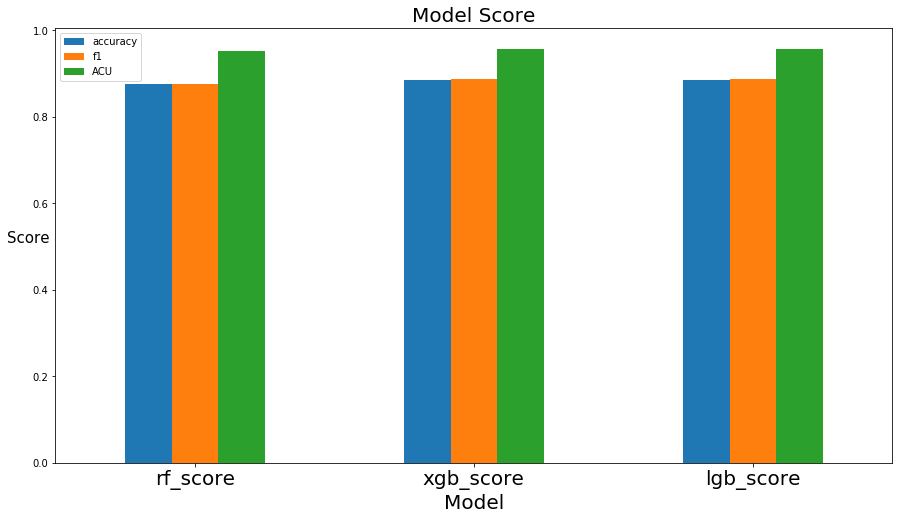

In [ ]:
score = pd.DataFrame((rf_score,xgb_score,lgb_score), index = ['rf_score','xgb_score','lgb_score'], columns= ['accuracy','f1','ACU'])

score.plot(kind="bar",figsize=(15, 8))
plt.title("Model Score",fontsize = 20)
plt.xticks(fontsize = 20,rotation = 0)
plt.xlabel("Model", fontsize = 20)
plt.ylabel("Score",rotation = 0,fontsize = 15);

score

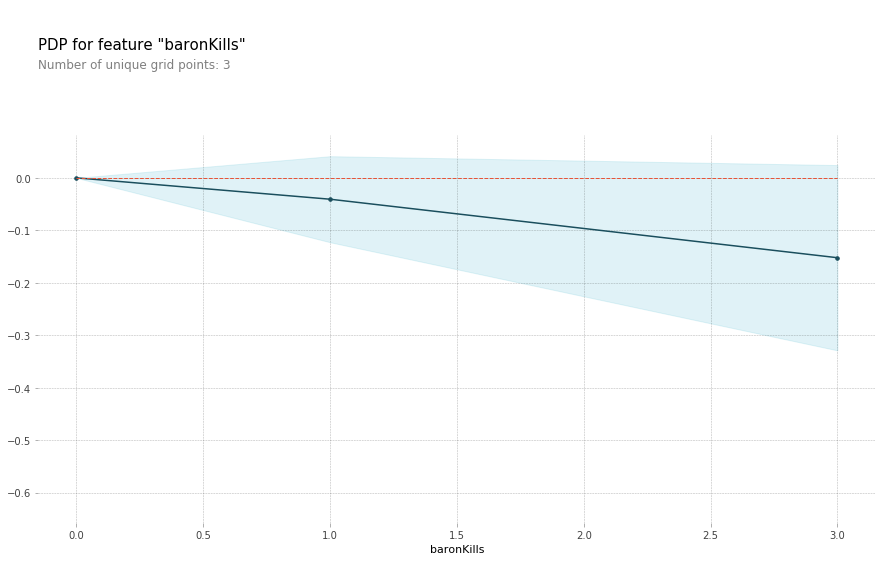

In [ ]:
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

shap.initjs();

isolated = pdp_isolate(
    model=xgb, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature='baronKills'
)

pdp_plot(isolated, feature_name = 'baronKills');

In [ ]:
ban_win = []
ban_lose = []
ban_win = pd.concat([df[df['win'] == True]['ban1'],df[df['win'] == True]['ban2']],axis = 0)
ban_win = pd.concat([ban_win,df[df['win'] == True]['ban3']],axis = 0)
ban_win = pd.concat([ban_win,df[df['win'] == True]['ban4']],axis = 0)
ban_win = pd.concat([ban_win,df[df['win'] == True]['ban5']],axis = 0)

ban_lose = pd.concat([df[df['win'] == False]['ban1'],df[df['win'] == False]['ban2']],axis = 0)
ban_lose = pd.concat([ban_lose,df[df['win'] == False]['ban3']],axis = 0)
ban_lose = pd.concat([ban_lose,df[df['win'] == False]['ban4']],axis = 0)
ban_lose = pd.concat([ban_lose,df[df['win'] == False]['ban5']],axis = 0)

ban_lose = ban_lose.reset_index(drop=True)
ban_win = ban_win.reset_index(drop=True)

ban_lose.value_counts()

In [ ]:
ban_win.value_counts()

In [ ]:
df

,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,championKills,towerKills,inhibitorKills,baronKills,dragonKills,riftHeraldKills,ban1,ban2,ban3,ban4,ban5
0,100,False,True,True,False,False,False,False,16,3,0,0,1,0,62,78,117,222,238
1,200,True,False,False,True,True,True,True,27,9,2,1,3,2,89,101,112,238,421
2,100,True,True,True,True,True,False,True,27,8,1,1,1,2,30,51,58,238,412
3,200,False,False,False,False,False,True,False,27,3,0,0,3,0,23,30,51,91,104
4,100,True,False,False,True,False,False,True,41,7,1,0,3,1,23,24,99,166,202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64501,200,False,False,False,False,True,False,False,20,0,0,1,0,0,81,89,112,223,711
64502,100,False,False,False,False,False,False,False,11,1,0,0,0,0,-1,7,39,166,555
64503,200,True,True,True,True,True,True,True,30,9,1,1,3,2,-1,24,53,89,238
64504,100,True,True,True,True,False,True,True,27,10,1,0,2,2,-1,84,91,131,238


In [ ]:
chal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/porject2/match_challanger.csv')

In [ ]:
##ban데이터중 필요한없는 문자열 제거
chal = chal.drop_duplicates()
chal = chal.drop(chal[chal['bans'].str.contains('\[\]')].index)       ##ban데이터가 아예없는 행제거
chal['bans'] = chal['bans'].str.replace(' ','', regex=True)
chal['bans'] = chal['bans'].str.replace('[','', regex=True)
chal['bans'] = chal['bans'].str.replace(']','', regex=True)
chal['bans'] = chal['bans'].str.replace('{','', regex=True)
chal['bans'] = chal['bans'].str.replace('}','', regex=True)
chal['bans'] = chal['bans'].str.replace('\'championId\':','', regex=True)
chal = chal.reset_index(drop = True)
chal['teamId'] = chal['teamId'].astype(object)

In [ ]:
##ban데이터 분할
ban = []
bans1 = []

for i in tqdm(range(len(chal['bans']))):
    ban = []
    for b in [0,2,4,6,8]:
        if b == 0:
            ban.append(chal['bans'][i].split(',')[b])
        elif b == 2:
            ban.append(chal['bans'][i].split(',')[b])
        elif b == 4:
            ban.append(chal['bans'][i].split(',')[b])
        elif b == 6:
            ban.append(chal['bans'][i].split(',')[b])
        elif b == 8:
            ban.append(chal['bans'][i].split(',')[b])
    ban = list(map(int, ban))
    ban = sorted(ban)
    bans1.append(ban)
bans = pd.DataFrame(bans1, columns=['ban1', 'ban2','ban3','ban4','ban5'])

100%|██████████| 10/10 [00:00<00:00, 5547.29it/s]


In [ ]:
target = 'win'
features = chal.drop(columns=[target]).columns

X_test = chal[features]
y_test = chal[target]


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
##------------- train ban PCA
pca = PCA(n_components=2)
bans = StandardScaler().fit_transform(bans)
pca.fit(bans)
bans_pca = pca.transform(bans)
ban_test = pd.DataFrame(bans_pca, columns= ['ban_pca1','ban_pca2'])
X_test = X_test.reset_index(drop= True)
X_test = pd.concat([X_test, ban_test], axis = 1)

In [ ]:
X_test = X_test.drop(['bans'],axis =1)        ##기존 bans행 제거
X_test = X_test.drop(['gameId'],axis =1)      ##gameId행 제거

In [ ]:
X_test_encoded = encoder.transform(X_test)

In [ ]:
X_test_encoded

,teamId,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,championKills,towerKills,inhibitorKills,baronKills,dragonKills,riftHeraldKills,ban_pca1,ban_pca2
0,2,False,True,True,False,False,True,40,8,2,1,1,1,0.017051,1.213603
1,1,True,False,False,True,True,False,42,9,4,2,5,1,-2.388494,2.650898
2,2,True,True,True,True,True,False,28,10,2,1,1,1,-0.640791,-1.070456
3,1,False,False,False,False,False,True,16,2,0,0,3,1,0.713906,-0.277784
4,2,True,True,True,False,True,True,29,8,1,0,1,2,-1.703796,-2.101446
5,1,False,False,False,False,False,False,19,2,0,0,0,0,2.396465,0.459422
6,2,False,True,False,False,True,True,36,4,0,0,2,2,1.750703,-0.042049
7,1,True,False,True,True,False,False,34,10,2,1,2,0,1.901779,0.334044
8,2,False,True,True,False,True,True,35,6,1,0,2,2,-1.942404,-0.249443
9,1,True,False,False,False,False,False,15,0,0,0,0,0,-0.104419,-0.916789


In [ ]:
y_pred_lgb = lgb.predict(X_test_encoded)
print(f'경기 횟수:', len(y_pred_lgb))
print(f'accuracy_score:', accuracy_score(y_test,y_pred_lgb))

경기 횟수: 10
accuracy_score: 0.9


In [ ]:
y_pred_lgb

array([ True,  True,  True, False,  True, False, False,  True,  True,
       False])